# Clasificación con Árboles de decisión

En este cuaderno trabajaremos con el conjunto de datos [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) de Kaggle. Nuestro objetivo será entrenar un árbol de decisión para predecir si las transacciones son legales o, por el contrario, fraudulentas.
Uno de los principales desafíos de este problema en particular es el evidente desbalanceo que existe entre clases, siendo que sólo un 0.172% de las instancias constituyen casos de fraude. Para paliar esa dificultad, emplearemos diferentes combinaciones de técnicas de reducción de características (mrMR, RFC) e instancias (CCSoft, CCHard, SLVQ).

En cuanto al clasificador, emplearemos `DecisionTreeClassifier` de sklearn, que si bien es una implementación del algoritmo `CART` que no permite tomar valores categóricos como entradas, esto no nos afectará, ya que todas las variables predictoras son continuas y teniendo la ventaja de no tener que importar software externo para hacerlo funcionar.

## Importamos los datos

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
import graphviz

In [57]:
data_path = './data/'

train_data = pd.read_csv(f'{data_path}train_data.csv')
test_data = pd.read_csv(f'{data_path}test_data.csv')

df_reduce_mrmr = pd.read_csv(f'{data_path}X_train_reduce_mrmr.csv')
df_reduce_mrmr_instances = pd.read_csv(f'{data_path}df_reduce_mrmr_instances.csv')
df_reduce_mrmr_instances_hard = pd.read_csv(f'{data_path}df_reduce_mrmr_instances_hard.csv')
df_reduce_mrmr_instances_GLVQ = pd.read_csv(f'{data_path}df_reduce_mrmr_instances_GLVQ.csv')

df_X_train_reduce_RFC = pd.read_csv(f'{data_path}df_X_train_reduce_RFC.csv')
df_reduce_RFC_instances = pd.read_csv(f'{data_path}df_reduce_RFC_instances.csv')
df_reduce_RFC_instances_hard = pd.read_csv(f'{data_path}df_reduce_RFC_instances_hard.csv')
df_reduce_RFC_instances_GLVQ = pd.read_csv(f'{data_path}df_reduce_RFC_instances_GLVQ.csv')

print("Datos cargados exitosamente:")
print(f"train_data: {train_data.shape}")
print(train_data["Class"].value_counts())
print(f"df_reduce_mrmr: {df_reduce_mrmr.shape}")
print(df_reduce_mrmr["Class"].value_counts())
print(f"df_reduce_mrmr_instances: {df_reduce_mrmr_instances.shape}")
print(df_reduce_mrmr_instances["Class"].value_counts())
print(f"df_reduce_mrmr_instances hard: {df_reduce_mrmr_instances_hard.shape}")
print(df_reduce_mrmr_instances_hard["Class"].value_counts())
print(f"df_reduce_mrmr_instances_GLVQ: {df_reduce_mrmr_instances_GLVQ.shape}")
print(df_reduce_mrmr_instances_GLVQ["Class"].value_counts())
print(f"df_X_train_reduce_RFC: {df_X_train_reduce_RFC.shape}")
print(df_X_train_reduce_RFC["Class"].value_counts())
print(f"df_reduce_RFC_instances: {df_reduce_RFC_instances.shape}")
print(df_reduce_RFC_instances["Class"].value_counts())
print(f"df_reduce_RFC_instances hard: {df_reduce_RFC_instances_hard.shape}")
print(df_reduce_RFC_instances_hard["Class"].value_counts())
print(f"df_reduce_RFC_instances_GLVQ: {df_reduce_RFC_instances_GLVQ.shape}")
print(df_reduce_RFC_instances_GLVQ["Class"].value_counts())

Datos cargados exitosamente:
train_data: (256326, 31)
Class
0    255883
1       443
Name: count, dtype: int64
df_reduce_mrmr: (256326, 11)
Class
0    255883
1       443
Name: count, dtype: int64
df_reduce_mrmr_instances: (886, 11)
Class
0    443
1    443
Name: count, dtype: int64
df_reduce_mrmr_instances hard: (886, 11)
Class
0    443
1    443
Name: count, dtype: int64
df_reduce_mrmr_instances_GLVQ: (2, 11)
Class
0    1
1    1
Name: count, dtype: int64
df_X_train_reduce_RFC: (256326, 11)
Class
0    255883
1       443
Name: count, dtype: int64
df_reduce_RFC_instances: (886, 11)
Class
0    443
1    443
Name: count, dtype: int64
df_reduce_RFC_instances hard: (886, 11)
Class
0    443
1    443
Name: count, dtype: int64
df_reduce_RFC_instances_GLVQ: (2, 11)
Class
0    1
1    1
Name: count, dtype: int64


## Árboles de decisión con mrMr y clusterCentroids_soft

### Optimización de hiperparámetros (GridSearchCV)

In [67]:
X = df_reduce_mrmr_instances.drop(columns=['Class'])
y = df_reduce_mrmr_instances['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensiones de los conjuntos:")
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

# Inicializamos tanto el clasificador como el algoritmo para optimizar los hiperparámetros
clf =  DecisionTreeClassifier(criterion = 'gini', random_state = 42, class_weight = 'balanced')
parametros = {
    'max_depth' : [3, 5, 8, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar GridSearchCV
#Usamos scoring f1 porque tiene mas sentido cuando existen clases desbalanceadas como es este caso
ajuste = GridSearchCV(clf, parametros, cv=10, scoring='f1', verbose=3)
ajuste.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = ajuste.best_estimator_.predict(X_test)
print(f"Mejores parámetros: {ajuste.best_params_}")
print(f"Precisión: {accuracy_score(y_test, y_pred):.2f}")

Dimensiones de los conjuntos:
Conjunto de entrenamiento: (708, 10), (708,)
Conjunto de prueba: (178, 10), (178,)
Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.986 total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.971 total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=1.000 total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.928 total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.930 total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.928 total time=   0.0s
[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.946 total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.944 total time=   0.0s
[CV 9/10] END max_depth=

### Visualizamos el árbol óptimo (graphviz)

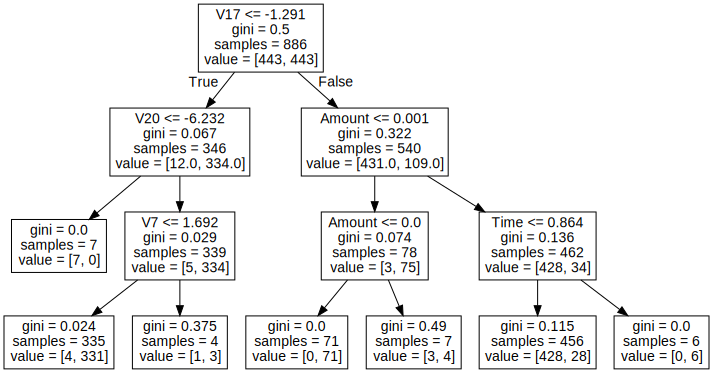

In [68]:
clf = DecisionTreeClassifier(
    criterion = 'gini',
    random_state = 42,
    class_weight = 'balanced',
    max_depth = 3,
    min_samples_leaf = 4,
    min_samples_split = 2
)
clf.fit(X,y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, impurity=True) 
graph = graphviz.Source(dot_data)
graph.render("tree_transactions")
display(graph)

### Validación empleando el conjunto de test

In [72]:
# Cogemos los datos de test y les eliminamos las características que no necesitamos
X_test = test_data.drop(columns=['Class'])
y_test_final = test_data['Class']
columns_to_keep_mrmr = ['V17', 'Time', 'Amount', 'V25', 'V20', 'V7', 'V13', 'V22', 'V19', 'V23']
X_test_reduce = X_test[columns_to_keep_mrmr]

#normalizamos la entrada
scaler = MinMaxScaler()
# Normalizar las columnas
X_test_reduce['Amount'] = scaler.fit_transform(X_test_reduce[['Amount']])
X_test_reduce['Time'] = scaler.fit_transform(X_test_reduce[['Time']])

print(y_test_final.value_counts())

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_reduce)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_final, y_pred)
report = classification_report(y_test_final, y_pred, target_names=['Correctas', 'Fraudulentas'])
# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

print("Reporte de Clasificación:")
print(report)

Class
0    28432
1       49
Name: count, dtype: int64
Matriz de confusión:
[[15400 13032]
 [    2    47]]
Reporte de Clasificación:
              precision    recall  f1-score   support

   Correctas       1.00      0.54      0.70     28432
Fraudulentas       0.00      0.96      0.01        49

    accuracy                           0.54     28481
   macro avg       0.50      0.75      0.35     28481
weighted avg       1.00      0.54      0.70     28481



C:\Users\Eugenio\AppData\Local\Temp\ipykernel_30384\1239554220.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduce['Amount'] = scaler.fit_transform(X_test_reduce[['Amount']])
C:\Users\Eugenio\AppData\Local\Temp\ipykernel_30384\1239554220.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduce['Time'] = scaler.fit_transform(X_test_reduce[['Time']])


## Árboles de decisión con mrMR y clusterCentroids_hard

### Optimización de hiperparámetros (GridSearchCV)

In [87]:
X = df_reduce_mrmr_instances_hard.drop(columns=['Class'])
y = df_reduce_mrmr_instances_hard['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensiones de los conjuntos:")
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

# Inicializamos tanto el clasificador como el algoritmo para optimizar los hiperparámetros
clf =  DecisionTreeClassifier(criterion = 'gini', random_state = 42, class_weight = 'balanced')
parametros = {
    'max_depth' : [3, 5, 8, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar GridSearchCV
#Usamos scoring f1 porque tiene mas sentido cuando existen clases desbalanceadas como es este caso
ajuste = GridSearchCV(clf, parametros, cv=10, scoring='f1', verbose=3)
ajuste.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = ajuste.best_estimator_.predict(X_test)
print(f"Mejores parámetros: {ajuste.best_params_}")
print(f"Precisión: {accuracy_score(y_test, y_pred):.2f}")

Dimensiones de los conjuntos:
Conjunto de entrenamiento: (708, 10), (708,)
Conjunto de prueba: (178, 10), (178,)
Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.875 total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.909 total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.857 total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.862 total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.882 total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.794 total time=   0.0s
[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.932 total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.822 total time=   0.0s
[CV 9/10] END max_depth=

### Visualizamos el árbol óptimo (graphviz)

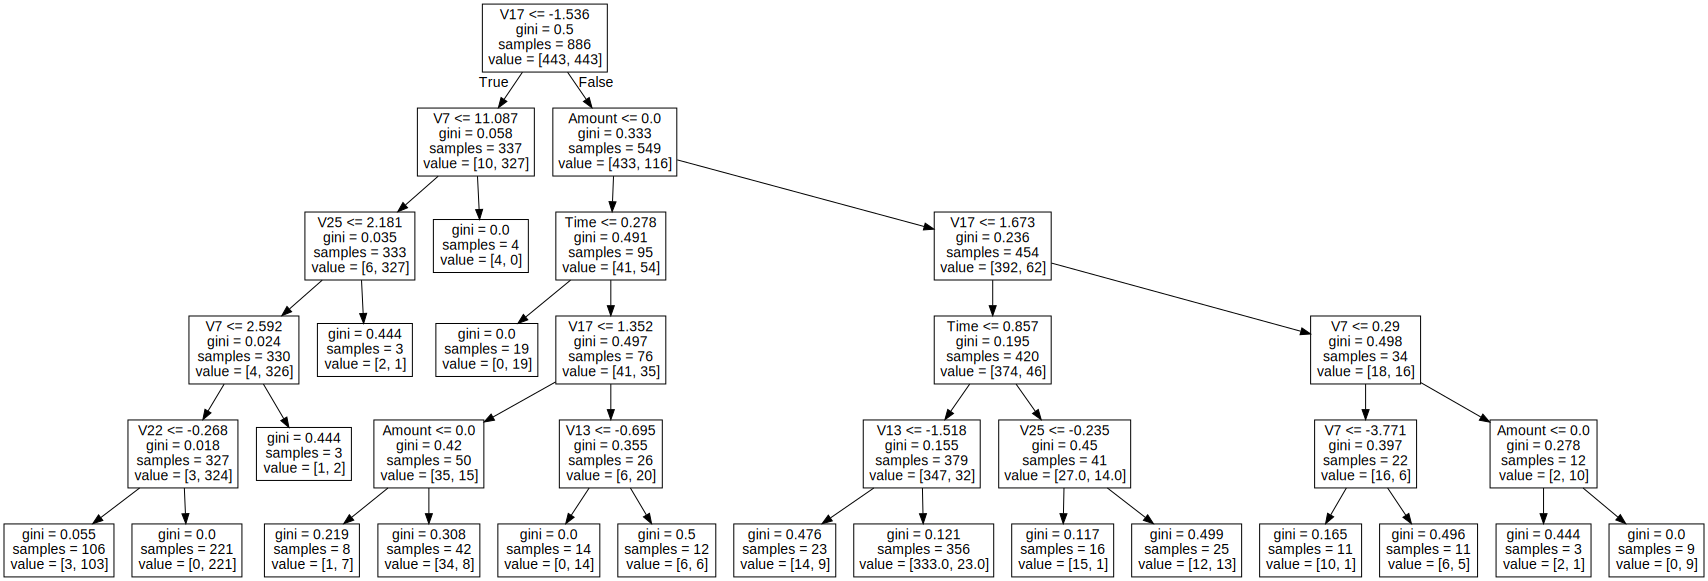

In [88]:
clf = DecisionTreeClassifier(
    criterion = 'gini',
    random_state = 42,
    class_weight = 'balanced',
    max_depth = 5,
    min_samples_leaf = 2,
    min_samples_split = 2
)
clf.fit(X,y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, impurity=True) 
graph = graphviz.Source(dot_data)
graph.render("tree_transactions")
display(graph)

### Validación empleando el conjunto de test

In [89]:
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_reduce)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_final, y_pred)
report = classification_report(y_test_final, y_pred, target_names=['Correctas', 'Fraudulentas'])
# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

print("Reporte de Clasificación:")
print(report)

Matriz de confusión:
[[25467  2965]
 [   12    37]]
Reporte de Clasificación:
              precision    recall  f1-score   support

   Correctas       1.00      0.90      0.94     28432
Fraudulentas       0.01      0.76      0.02        49

    accuracy                           0.90     28481
   macro avg       0.51      0.83      0.48     28481
weighted avg       1.00      0.90      0.94     28481



## Árboles de decisión con mrMR y GLVQ

### Optimización de hiperparámetros

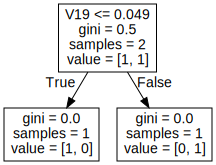

Usando GLVQ tenemos una precisión de 0.53


In [90]:
X = df_reduce_mrmr_instances_GLVQ.drop(columns=['Class'])
y = df_reduce_mrmr_instances_GLVQ['Class']

clf = DecisionTreeClassifier(
    criterion = 'gini',
    random_state = 42,
    class_weight = 'balanced',
    max_depth = 2,
    min_samples_leaf = 1,
    min_samples_split = 2
)
clf.fit(X, y)

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, impurity=True) 
graph = graphviz.Source(dot_data)
graph.render("tree_transactions")
display(graph)

accuracy = clf.score(X_test_reduce, y_test_final)

print(f"Usando GLVQ tenemos una precisión de {accuracy:.2f}")

### Validación empleando el conjunto de test

In [91]:
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_reduce)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_final, y_pred)
report = classification_report(y_test_final, y_pred, target_names=['Correctas', 'Fraudulentas'])
# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

print("Reporte de Clasificación:")
print(report)

Matriz de confusión:
[[15124 13308]
 [   11    38]]
Reporte de Clasificación:
              precision    recall  f1-score   support

   Correctas       1.00      0.53      0.69     28432
Fraudulentas       0.00      0.78      0.01        49

    accuracy                           0.53     28481
   macro avg       0.50      0.65      0.35     28481
weighted avg       1.00      0.53      0.69     28481



## Árboles de decisión con RFC clusterCentroids_soft

### Optimización de hiperparámetros (GridSearchCV)

In [104]:
X = df_reduce_RFC_instances.drop(columns=['Class'])
y = df_reduce_RFC_instances['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializamos tanto el clasificador como el algoritmo para optimizar los hiperparámetros
clf =  DecisionTreeClassifier(criterion = 'gini', random_state = 42, class_weight = 'balanced')
parametros = {
    'max_depth' : [3, 6, 8, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar GridSearchCV
#Usamos scoring f1 porque tiene mas sentido cuando existen clases desbalanceadas como es este caso
ajuste = GridSearchCV(clf, parametros, cv=10, scoring='f1', verbose=3)
ajuste.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = ajuste.best_estimator_.predict(X_test)
print(f"Mejores parámetros: {ajuste.best_params_}")
print(f"Precisión: {accuracy_score(y_test, y_pred):.2f}")

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.862 total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.866 total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.892 total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.914 total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.912 total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.866 total time=   0.0s
[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.919 total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.930 total time=   0.0s
[CV 9/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.877 total time=   0.0s
[CV 10/10] END max_depth=3, min_sampl

### Visualizamos el árbol óptimo (graphviz)

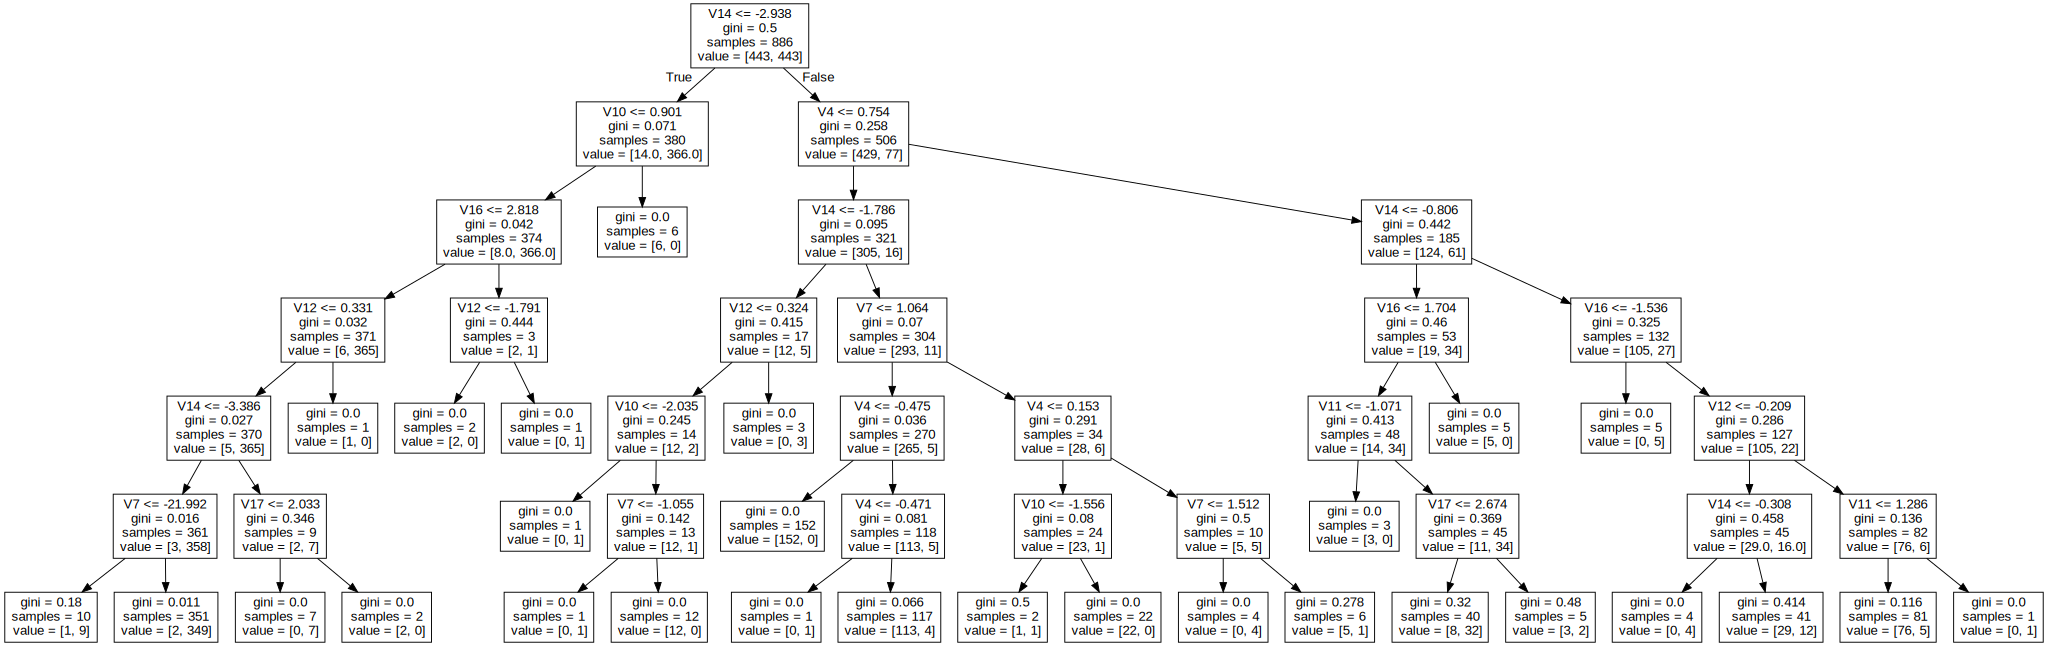

In [102]:
clf = DecisionTreeClassifier(
    criterion = 'gini',
    random_state = 42,
    class_weight = 'balanced',
    max_depth = 6,
    min_samples_leaf = 1,
    min_samples_split = 2
)
clf.fit(X,y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, impurity=True) 
graph = graphviz.Source(dot_data)
graph.render("tree_transactions")
display(graph)

### Validación empleando el conjunto de test

In [103]:
# Cogemos los datos de test y les eliminamos las características que no necesitamos
X_test = test_data.drop(columns=['Class'])
y_test_final = test_data['Class']
columns_to_keep_RFC = ['V17', 'V16', 'V12', 'V14', 'V11', 'V10', 'V9', 'V4', 'V18', 'V7']
X_test_reduce = X_test[columns_to_keep_RFC]

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_reduce)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_final, y_pred)
report = classification_report(y_test_final, y_pred, target_names=['Correctas', 'Fraudulentas'])
# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

print("Reporte de Clasificación:")
print(report)

Matriz de confusión:
[[26735  1697]
 [    7    42]]
Reporte de Clasificación:
              precision    recall  f1-score   support

   Correctas       1.00      0.94      0.97     28432
Fraudulentas       0.02      0.86      0.05        49

    accuracy                           0.94     28481
   macro avg       0.51      0.90      0.51     28481
weighted avg       1.00      0.94      0.97     28481



## Árboles de decisión con RFC clusterCentroids_hard

### Optimización de hiperparámetros (GridSearchCV)

In [105]:
X = df_reduce_RFC_instances_hard.drop(columns=['Class'])
y = df_reduce_RFC_instances_hard['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensiones de los conjuntos:")
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

# Inicializamos tanto el clasificador como el algoritmo para optimizar los hiperparámetros
clf =  DecisionTreeClassifier(criterion = 'gini', random_state = 42, class_weight = 'balanced')
parametros = {
    'max_depth' : [3, 5, 8, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar GridSearchCV
#Usamos scoring f1 porque tiene mas sentido cuando existen clases desbalanceadas como es este caso
ajuste = GridSearchCV(clf, parametros, cv=10, scoring='f1', verbose=3)
ajuste.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = ajuste.best_estimator_.predict(X_test)
print(f"Mejores parámetros: {ajuste.best_params_}")
print(f"Precisión: {accuracy_score(y_test, y_pred):.2f}")

Dimensiones de los conjuntos:
Conjunto de entrenamiento: (708, 10), (708,)
Conjunto de prueba: (178, 10), (178,)
Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV 1/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.896 total time=   0.0s
[CV 2/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.912 total time=   0.0s
[CV 3/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.958 total time=   0.0s
[CV 4/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.909 total time=   0.0s
[CV 5/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.914 total time=   0.0s
[CV 6/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.909 total time=   0.0s
[CV 7/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.944 total time=   0.0s
[CV 8/10] END max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.886 total time=   0.0s
[CV 9/10] END max_depth=

### Visualizamos el árbol óptimo (graphviz)

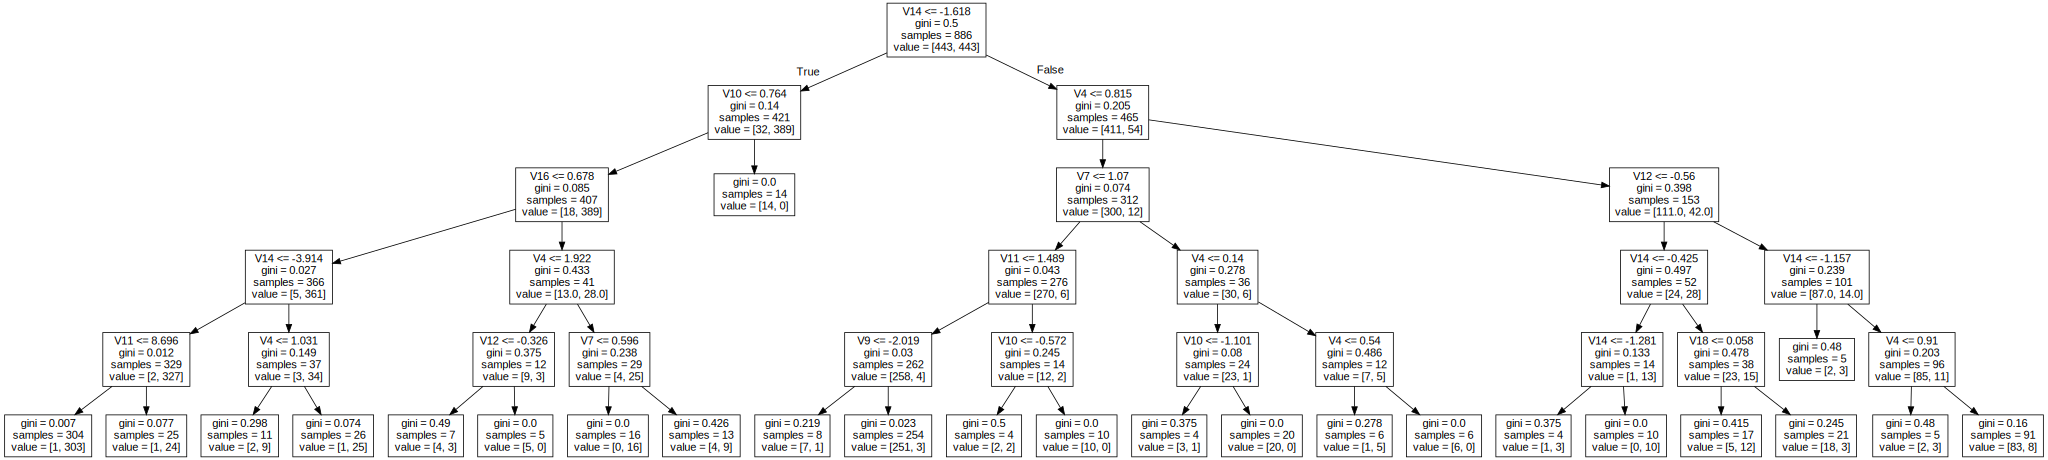

In [106]:
clf = DecisionTreeClassifier(
    criterion = 'gini',
    random_state = 42,
    class_weight = 'balanced',
    max_depth = 5,
    min_samples_leaf = 4,
    min_samples_split = 2
)
clf.fit(X,y)
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, impurity=True) 
graph = graphviz.Source(dot_data)
graph.render("tree_transactions")
display(graph)

### Validación empleando el conjunto de test

In [107]:
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_reduce)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_final, y_pred)
report = classification_report(y_test_final, y_pred, target_names=['Correctas', 'Fraudulentas'])
# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

print("Reporte de Clasificación:")
print(report)

Matriz de confusión:
[[26567  1865]
 [    7    42]]
Reporte de Clasificación:
              precision    recall  f1-score   support

   Correctas       1.00      0.93      0.97     28432
Fraudulentas       0.02      0.86      0.04        49

    accuracy                           0.93     28481
   macro avg       0.51      0.90      0.50     28481
weighted avg       1.00      0.93      0.96     28481



## Árboles de decisión con RFC y GLVQ

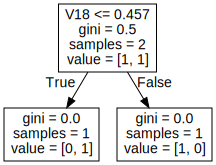

Usando GLVQ tenemos una precisión de 0.27


In [110]:
X = df_reduce_RFC_instances_GLVQ.drop(columns=['Class'])
y = df_reduce_RFC_instances_GLVQ['Class']

clf = DecisionTreeClassifier(
    criterion = 'gini',
    random_state = 42,
    class_weight = 'balanced',
    min_samples_leaf = 1,
    min_samples_split = 2
)
clf.fit(X, y)

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, impurity=True) 
graph = graphviz.Source(dot_data)
graph.render("tree_transactions")
display(graph)

accuracy = clf.score(X_test_reduce, y_test_final)

print(f"Usando GLVQ tenemos una precisión de {accuracy:.2f}")

## Validación empleando el conjunto de test

In [111]:
# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_reduce)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_final, y_pred)
report = classification_report(y_test_final, y_pred, target_names=['Correctas', 'Fraudulentas'])
# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

print("Reporte de Clasificación:")
print(report)

Matriz de confusión:
[[ 7639 20793]
 [    7    42]]
Reporte de Clasificación:
              precision    recall  f1-score   support

   Correctas       1.00      0.27      0.42     28432
Fraudulentas       0.00      0.86      0.00        49

    accuracy                           0.27     28481
   macro avg       0.50      0.56      0.21     28481
weighted avg       1.00      0.27      0.42     28481



## Conclusiones

En líneas generales podemos observar que, si bien se introduce una mejora en la capacidad predictiva del árbol de decisión empleando el dataset filtrado mediante RFC, las técnicas de reducción de variables y equilibrado de instancias resultan insuficientes. Sorpresivamente esto ocurre porque, en lugar de estar profundamente sesgado por las transacciones no fraudulentas, el clasificador es hábil detectando las transacciones no fraudulentas correctamente y no tanto las no fraudulentas, que son en última instancia, la clase ampliamente mayoritaria. Como comentario adicional, cabe mencionar que SLVQ es incapaz de limitar el modelo lo suficiente como para crear un buen clasificador.